# Bone Age Prediction

In [1]:
!nvidia-smi
# !pip install scikit-image
# !python -m pip install -U pip
# !python -m pip install -U matplotlib
# https://stackoverflow.com/questions
# https://en.wikipedia.org/wiki/Whitening_transformation 
# https://keras.io/callbacks/ 

Thu Apr 23 11:35:22 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.33.01    Driver Version: 440.33.01    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce RTX 208...  On   | 00000000:1A:00.0 Off |                  N/A |
| 30%   34C    P2    58W / 250W |   3927MiB / 11019MiB |      4%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce RTX 208...  On   | 00000000:1B:00.0 Off |                  N/A |
| 31%   27C    P8    22W / 250W |  10998MiB / 11019MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  G

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn
import seaborn as sn
import os
from random import shuffle
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import csv
import sys
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dense, Dropout, Flatten, Lambda, Average
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import *
from tensorflow.keras.losses import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from scipy.ndimage.filters import gaussian_filter
from scipy.ndimage.interpolation import map_coordinates
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import load_model
# import torch
# import torch.nn as nn
# import torch.optim as optim
# import torch.utils.data as data
# from torch.utils.data.dataset import Dataset
# import torch.nn.functional as F
# from torch.autograd import Variable
# import torchvision
# import torchvision.datasets as datasets
# import torchvision.transforms as transforms
from skimage import data, color
from skimage.transform import rescale, resize, downscale_local_mean
from PIL import Image
from PIL import ImageOps
from tqdm.notebook import tqdm
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score

%matplotlib inline
sn.set()
stderr = sys.stderr
sys.stderr = open(os.devnull, 'w')
sys.stderr = stderr
os.environ["CUDA_VISIBLE_DEVICES"]="5"
rowOld = 512
colOld = 512
row = 128
col = 128
numBin = 4
import os
for dirname, _, filenames in os.walk('/rsna-bone-age'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
def imcrop(im, new_width, new_height):
    width, height = im.size 

    left = (width - new_width)/2
    top = (height - new_height)/2
    right = (width + new_width)/2
    bottom = (height + new_height)/2

    im = im.crop((left, top, right, bottom))
    im = im.resize((row,col))
    return im

input_shape = (rowOld,colOld)


Bad key "text.kerning_factor" on line 4 in
/home/mcb/users/dlim63/miniconda3/envs/research/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution
/home/mcb/users/dlim63/miniconda3/envs/research/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/mcb/users/dlim63/miniconda3/envs/research/lib/python3.7/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dt

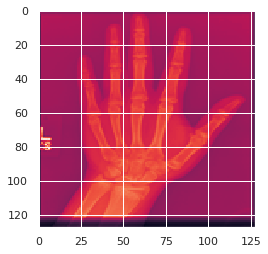

In [3]:
def learningCurve(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
im = Image.open('rsna-bone-age/boneage-training-dataset/boneage-training-dataset/{}.png'.format(2000))
im2 = im.resize((128,128), Image.ANTIALIAS)
imshow(im2)

## Preprocessing Images
1. Downsampling the image to 128 X128
2. Normalizing the Images


     id  boneage   male
0  1377      180  False
1  1378       12  False
2  1379       94  False
3  1380      120   True
4  1381       82  False


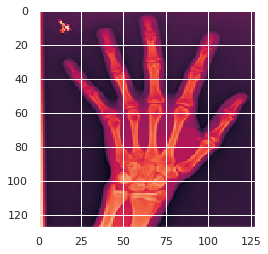

In [4]:
label = pd.read_csv('rsna-bone-age/boneage-training-dataset.csv')
imshow(Image.open('rsna-bone-age/boneage-training-dataset/boneage-training-dataset/{}.png'.format(2000)))

X = []

for i in tqdm(label['id']):
    im = Image.open('rsna-bone-age/boneage-training-dataset/boneage-training-dataset/{}.png'.format(i))
#     print(im.size)
#     im = imcrop(im, rowOld, colOld)
    im = im.resize((row,col), Image.ANTIALIAS)
    X.append(np.array(im))
                    
print(label.head())

imshow(X[0].reshape(row,col))

## Preprocessing Labels
1. Make 4 Equal Sized Ranges
2. One-hot encode Labels

In [5]:
label['ageBin'] = pd.qcut(label['boneage'], q=numBin, labels = range(numBin))

meanDict = {}
for i in range(numBin):
    meanDict[i] = label[label['ageBin']==i]['boneage'].mean()
label['meanBin'] = label['ageBin'].map(meanDict)    
    
y = label['ageBin']

X = np.asarray(X)
X = X.astype('float32')
# X /= 255
X = ((X-np.mean(X))/np.std(X))
# subtract the mean / std in scikit learn
# pca whitening searing (later)
X = X.reshape(-1, row, col, 1)
print(X)
y = label['ageBin']
enc = OneHotEncoder(handle_unknown='ignore')
encSex = OneHotEncoder(handle_unknown='ignore')
enc.fit(np.asarray(y).reshape(-1, 1))
encSex.fit(np.array(label['male']).reshape(-1, 1))
enc.categories_
y = enc.transform(np.asarray(y).reshape(-1, 1)).toarray()
y_sex = encSex.transform(np.asarray(label['male']).reshape(-1, 1)).toarray()
X_train, X_test, y_train, y_test, y_train_mean, y_test_mean, y_train_int, y_test_int, y_train_sex, y_test_sex = train_test_split(X, y,np.array(label['meanBin']), np.array(label['boneage']), y_sex, test_size=0.2, random_state=111)

print(label.sample(10))
print(X.shape)

[[[[ 3.9943082 ]
   [ 2.631847  ]
   [ 1.0660331 ]
   ...
   [ 0.45597574]
   [ 0.47631097]
   [ 0.49664623]]

  [[ 3.9943082 ]
   [ 2.6725173 ]
   [ 1.0660331 ]
   ...
   [ 0.41530523]
   [ 0.41530523]
   [ 0.45597574]]

  [[ 3.973973  ]
   [ 2.713188  ]
   [ 1.0863683 ]
   ...
   [ 0.39497   ]
   [ 0.41530523]
   [ 0.41530523]]

  ...

  [[ 3.5876033 ]
   [ 3.6486092 ]
   [ 3.7502854 ]
   ...
   [-0.05240539]
   [-0.07274064]
   [-0.07274064]]

  [[ 3.5876033 ]
   [ 3.6689444 ]
   [ 3.7502854 ]
   ...
   [-0.03207015]
   [-0.03207015]
   [-0.03207015]]

  [[ 3.6079388 ]
   [ 3.6689444 ]
   [ 3.7706206 ]
   ...
   [ 0.00860034]
   [ 0.02893559]
   [ 0.02893559]]]


 [[[ 1.6760904 ]
   [ 1.6760904 ]
   [ 1.6760904 ]
   ...
   [ 1.6557552 ]
   [ 1.6760904 ]
   [ 1.6557552 ]]

  [[ 1.6760904 ]
   [ 1.6760904 ]
   [ 1.6760904 ]
   ...
   [ 1.6760904 ]
   [ 1.6760904 ]
   [ 1.6557552 ]]

  [[ 1.6760904 ]
   [ 1.6760904 ]
   [ 1.6760904 ]
   ...
   [ 1.6557552 ]
   [ 1.6760904 ]
   [ 1.6557

## Building the CNN Model

In [6]:

model = Sequential([
        Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(row, col, 1)),
        Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),

        Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
        Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),

        Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'),
        Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'),
        Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),

        # Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'),
        # Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'),
        # Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'),
        # BatchNormalization(),
        # MaxPooling2D(pool_size=(2, 2)),
        # Dropout(0.25),

        Flatten(),

        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(numBin, activation='softmax')
    ])

model2 = Sequential([
    # different kernel sizes (1,1), (5,5) etc
    # Reduce the number of channels, 4, 5 channels
    # have multiple convolutions side by side (3,3) and (2,2) and concatenate. (later)
    # Age float (means squared error) (1, 1)
    # Median of the training set
        Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(row, col, 1)),
        Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'),
        BatchNormalization(),
#         MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),

        Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
        Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
        BatchNormalization(),
#         MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),

        Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'),
        Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'),
        Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'),
        BatchNormalization(),
#         MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),

        Flatten(),

        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.5), # afterwards try decreasing the dropout, or put the dropout before the layers
        Dense(numBin, activation='softmax') # use relu or linear when predicting one real number. Median(or mean) of the training set bracket. 
    ])# If we need more data samples, we could crop different regions

model3 = Sequential([
        Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(row, col, 1)),
        Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),

        Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
        Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),

        Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'),
        Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'),
        Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),

        # Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'),
        # Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'),
        # Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'),
        # BatchNormalization(),
        # MaxPooling2D(pool_size=(2, 2)),
        # Dropout(0.25),

        Flatten(),

        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(1, activation='relu')
        
    ])
model4 = Sequential([
        Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(row, col, 1)),
        Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),

        Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
        Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),

        Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'),
        Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'),
        Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),

        # Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'),
        # Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'),
        # Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'),
        # BatchNormalization(),
        # MaxPooling2D(pool_size=(2, 2)),
        # Dropout(0.25),

        Flatten(),

        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(2, activation='relu')
        
    ])

## Train and Draw the learning Curve

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 32)      320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 32)      9248      
_________________________________________________________________
batch_normalization (BatchNo (None, 128, 128, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 64, 64)        3

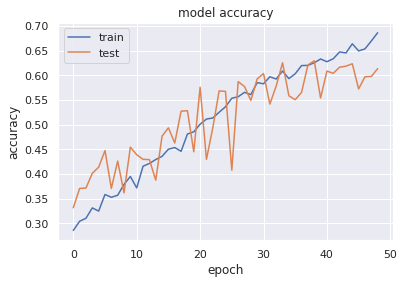

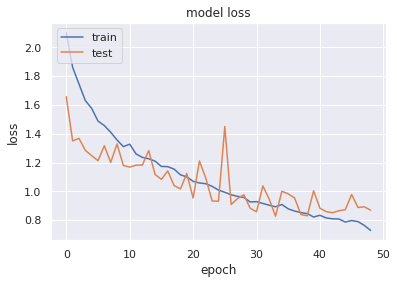

In [7]:
def customLoss(yTrue,yPred):
    pred = np.dot(yPred, np.array(meanDict.values()))
    result = ((yTrue - pred)**2).mean(axis=ax)
    return result

batch_size = 8# smaller batchsize 32 16 8
epochs = 100
learning_rate = 0.0001

def train(filepath, model, target, opt, loss):
    callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
    checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True)

    model.compile(loss=loss,
                      optimizer=opt, #Adagrad(no momentum more stable), SGD with momentum 0.9, learning rate 0.0001 try smaller later
                      metrics=['accuracy'])   
    model.summary()
    print(y_train)

    history = model.fit(X_train, target,
                            batch_size=batch_size,
                            epochs=epochs,
                            callbacks=[callback, checkpoint],
                            verbose=1,
                            shuffle = 'batch',
                            validation_split = 0.2,
    #                         class_weight=class_weights
                       )
    learningCurve(history)
    
train('ckpt/model1_{}'.format(numBin),model, y_train, Adam(lr=learning_rate), categorical_crossentropy)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 128, 128, 32)      320       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 128, 128, 32)      9248      
_________________________________________________________________
batch_normalization_5 (Batch (None, 128, 128, 32)      128       
_________________________________________________________________
dropout_5 (Dropout)          (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 128, 128, 64)      18496     
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 128, 128, 64)      36928     
_________________________________________________________________
batch_normalization_6 (Batch (None, 128, 128, 64)     

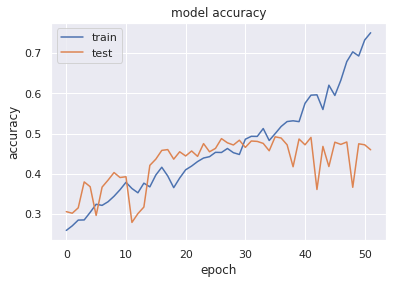

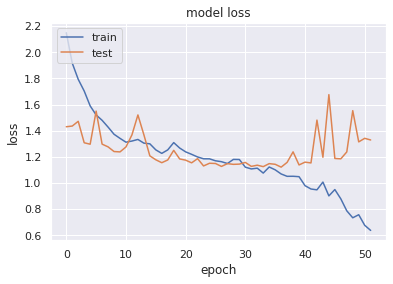

In [8]:
train('ckpt/model2_{}'.format(numBin),model2, y_train, Adam(lr=learning_rate), categorical_crossentropy)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 128, 128, 32)      320       
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 128, 128, 32)      9248      
_________________________________________________________________
batch_normalization_10 (Batc (None, 128, 128, 32)      128       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 64, 64, 64)        18496     
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 64, 64, 64)       

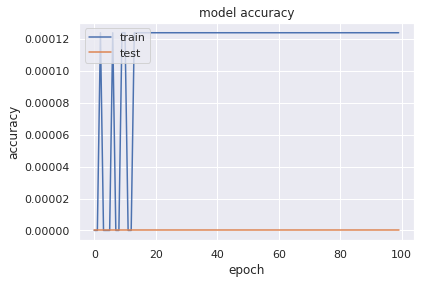

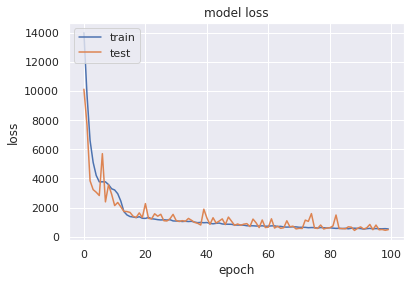

In [9]:
train('ckpt/integer_{}'.format(numBin),model3, y_train_int, Adam(lr=learning_rate), mse)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 128, 128, 32)      320       
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 128, 128, 32)      9248      
_________________________________________________________________
batch_normalization_15 (Batc (None, 128, 128, 32)      128       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
dropout_15 (Dropout)         (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 64, 64, 64)        18496     
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 64, 64, 64)       

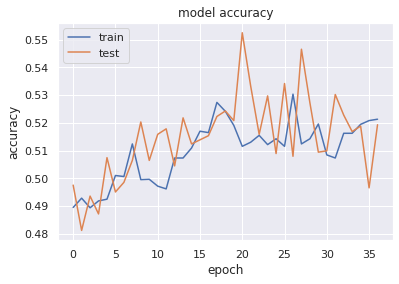

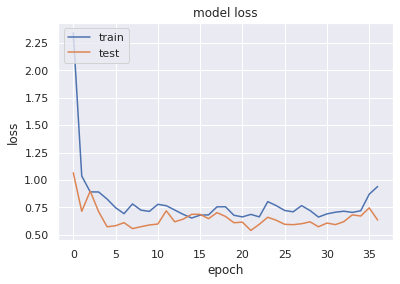

In [10]:
train('ckpt/model1_sex_{}'.format(numBin),model4, y_train_sex, Adam(lr=learning_rate), categorical_crossentropy)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 128, 128, 32)      320       
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 128, 128, 32)      9248      
_________________________________________________________________
batch_normalization_10 (Batc (None, 128, 128, 32)      128       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 64, 64, 64)        18496     
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 64, 64, 64)       

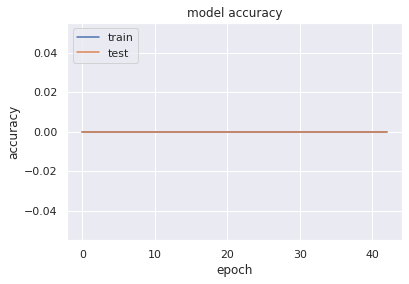

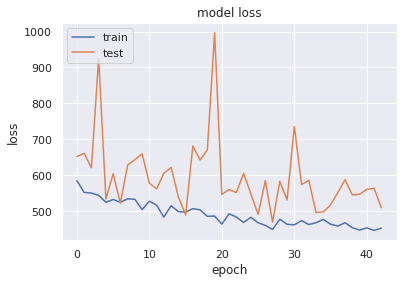

In [11]:
train('ckpt/model1_mean_{}'.format(numBin), model3, y_train_mean, Adam(lr=learning_rate), mse)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 32)      320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 32)      9248      
_________________________________________________________________
batch_normalization (BatchNo (None, 128, 128, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 64, 64)        3

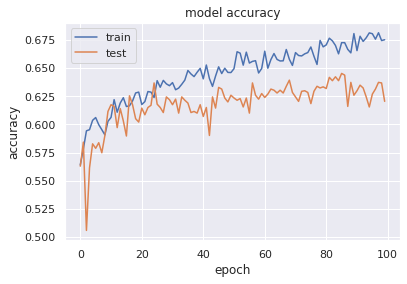

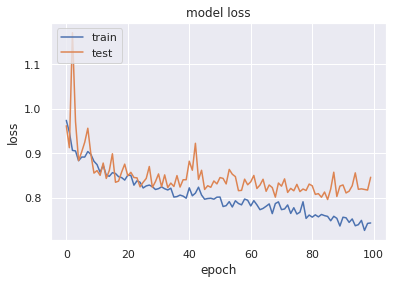

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 32)      320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 32)      9248      
_________________________________________________________________
batch_normalization (BatchNo (None, 128, 128, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 64, 64)        3

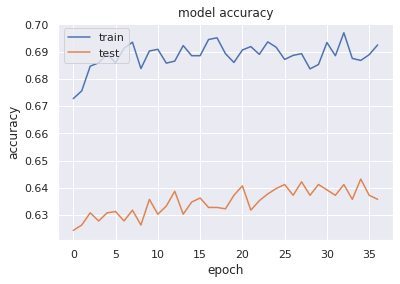

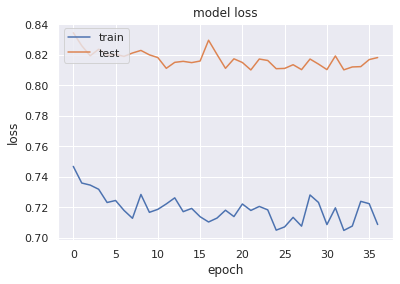

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 32)      320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 32)      9248      
_________________________________________________________________
batch_normalization (BatchNo (None, 128, 128, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 64, 64, 64)        3

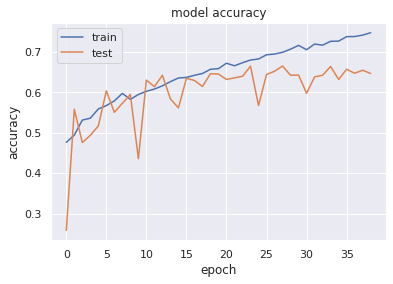

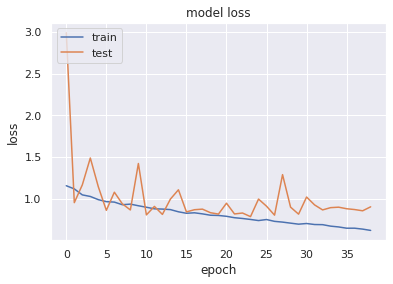

In [12]:
train('ckpt/model1_SGD_{}'.format(numBin),model, y_train, SGD(lr=learning_rate, decay=1e-6, momentum=0.9, nesterov=True), categorical_crossentropy)
train('ckpt/model1_adagrad_{}'.format(numBin),model, y_train, Adagrad(lr=learning_rate), categorical_crossentropy)
train('ckpt/model1_rmsProp_{}'.format(numBin),model, y_train, RMSprop(lr=0.001, rho=0.9), categorical_crossentropy)

In [13]:
predicted = model.predict(X_test)
print(predicted)
print(accuracy_score(tf.argmax(predicted, 1), tf.argmax(y_test,1)))
for a, b in zip(np.argmax(predicted, 1), np.argmax(y_test,1)):
    print(a, b)

[[7.0122145e-03 3.6404052e-01 6.0164380e-01 2.7303377e-02]
 [7.7013305e-05 7.3303051e-02 4.9951911e-01 4.2710081e-01]
 [7.1439222e-02 6.6682196e-01 2.5607195e-01 5.6669349e-03]
 ...
 [1.8878772e-03 3.0141246e-01 4.6897843e-01 2.2772124e-01]
 [8.7154103e-06 3.2609567e-02 2.6347271e-01 7.0390904e-01]
 [1.0075985e-06 2.2059015e-04 6.9351760e-03 9.9284327e-01]]
0.6686484344034879
2 0
2 3
1 1
2 2
1 1
1 2
0 0
0 0
3 2
1 0
2 1
0 0
0 0
0 0
1 1
3 1
3 2
3 3
2 2
2 2
0 0
3 3
1 1
3 3
0 0
0 0
2 1
0 1
0 0
0 0
0 0
2 2
3 3
3 3
3 3
2 2
0 0
3 3
1 1
3 3
1 2
0 0
3 3
0 0
3 3
3 3
3 3
1 1
3 3
3 3
1 2
1 1
0 0
2 2
2 1
0 0
2 1
3 3
3 1
2 2
1 0
3 2
3 2
0 2
0 0
3 1
1 2
0 1
1 2
3 3
1 1
1 2
3 2
2 2
1 1
0 1
3 1
3 3
1 1
3 3
0 0
3 3
0 0
0 0
1 1
2 2
2 2
3 3
2 3
3 3
1 1
3 3
1 1
0 0
1 1
1 2
1 1
2 1
2 1
3 3
2 2
3 3
0 0
2 1
3 2
3 2
2 2
0 0
0 0
3 3
0 1
2 2
0 0
2 3
2 1
1 1
3 3
1 2
0 0
1 1
2 2
1 1
3 3
1 1
0 0
2 2
3 2
2 2
2 2
3 3
3 3
0 1
0 0
0 0
0 1
0 0
1 2
2 1
0 0
1 1
3 2
2 2
1 1
2 1
3 3
3 2
0 2
0 0
1 2
3 3
1 1
2 1
3 2
0 0
1 2
1

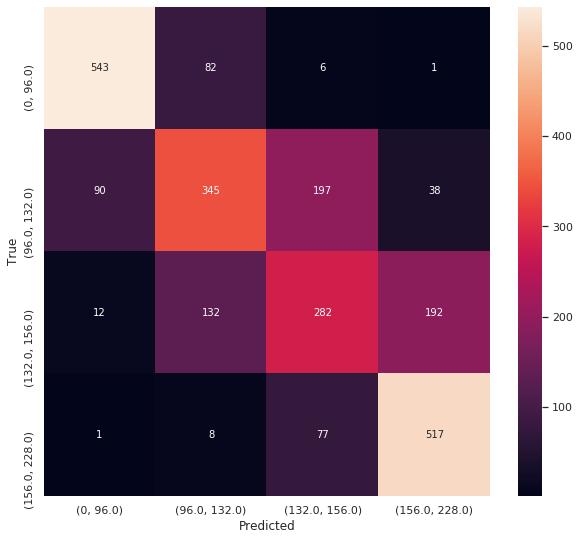

[[543  82   6   1]
 [ 90 345 197  38]
 [ 12 132 282 192]
 [  1   8  77 517]]
     id  boneage   male ageBin     meanBin
0  1377      180  False      3  175.296763
1  1378       12  False      0   70.955077
2  1379       94  False      0   70.955077
3  1380      120   True      1  120.245198
4  1381       82  False      0   70.955077
5  1382      138   True      2  148.637686
6  1383      150   True      2  148.637686
7  1384      156   True      2  148.637686
8  1385       36   True      0   70.955077
9  1387      138   True      2  148.637686
{0, 1, 2, 3}


In [14]:
labels = set(label['ageBin'])
bins =  [(0, 96.0), (96.0, 132.0), (132.0, 156.0), (156.0, 228.0)]
# print(labels)
cm = confusion_matrix(np.argmax(y_test,1),np.argmax(predicted, 1), labels=[0,1,2,3])
df_cm = pd.DataFrame(cm, index = bins, columns = bins)
plt.figure(figsize = (10,9))
sn.heatmap(df_cm, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show(block = False);
print(cm)
print(label.head(10))
print(labels)

      id  boneage   male ageBin     meanBin
0   1377      180  False      3  175.296763
1   1378       12  False      0   70.955077
2   1379       94  False      0   70.955077
3   1380      120   True      1  120.245198
4   1381       82  False      0   70.955077
5   1382      138   True      2  148.637686
6   1383      150   True      2  148.637686
7   1384      156   True      2  148.637686
8   1385       36   True      0   70.955077
9   1387      138   True      2  148.637686
10  1388      126  False      1  120.245198
11  1389      138   True      2  148.637686
12  1390      156   True      2  148.637686
13  1391      180   True      3  175.296763
14  1393      132  False      1  120.245198
15  1394       57   True      0   70.955077
16  1395      120  False      1  120.245198
17  1396      188  False      3  175.296763
18  1398        4  False      0   70.955077
19  1399       36  False      0   70.955077
148.6376858435682


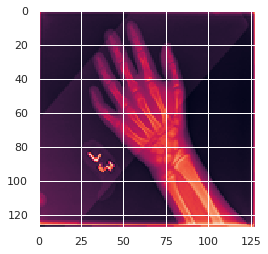

In [15]:
# using sex in the input : 
# keras graphs 
# in the output : predicting sex with images
# Try tuning at the same time. we have 2 losses(age, sex) add 2 losses together to back propagate. 
imshow(X_train[302].reshape(row,col))
print(label.head(20))
print(label[label['ageBin']==2]['boneage'].mean())